# Making a pipeline for the baseline patient

In [1]:
from sz_utils import data_handler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# check if gpu is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-12 23:16:44.482131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 23:16:45.674186: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-03-12 23:16:45.674384: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-03-12 23:16:45.683126: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-03-12 23:16:48.286232: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load training data

In [2]:
preictal, interictal = data_handler.make_patient_windows("chb01")

Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


Extracting EDF parameters from /mnt/e/Documents/projects/seizure-prediction/data/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/mnsosa/projects/SeizurePrediction/src/sz_utils/data_handler.py:78: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  mne_data = mne.io.read_raw_edf(edf_path)


In [3]:
# shapes
print(preictal.shape)
print(interictal.shape)

(420, 1280, 22)
(420, 1280, 22)


## Make dataset for baseline patient

In [29]:
# x_train is a list of preictal samples
# y_train is a list of labels for the preictal samples
# x_train has shape (n, 1280, 22)
# y_train has shape (n, 1)
# n is the number of preictal samples
# if x_train[i] is a preictal sample, then y_train[i] is 1

X = np.concatenate((preictal, interictal), axis=0)
y = np.concatenate((np.ones((preictal.shape[0], 1)), np.zeros((interictal.shape[0], 1))), axis=0)

print("X:", X.shape)
print("y:", y.shape)
print("How many y=1:", np.sum(y))
print("How many y=0:", y.shape[0] - np.sum(y))

X: (840, 1280, 22)
y: (840, 1)
How many y=1: 420.0
How many y=0: 420.0


In [30]:
# Shuffle the data
shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle_indices]
y = y[shuffle_indices]

In [31]:
# Split the data into train and test
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [32]:
# Split test data into validation and test
val_size = int(X_test.shape[0] * 0.5)
X_val = X_test[:val_size]
y_val = y_test[:val_size]
X_test = X_test[val_size:]
y_test = y_test[val_size:]

In [33]:
# Shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (672, 1280, 22)
y_train: (672, 1)
X_val: (84, 1280, 22)
y_val: (84, 1)
X_test: (84, 1280, 22)
y_test: (84, 1)


## Make model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

In [35]:
# make model
model = Sequential()

model.add(Conv1D(256, 3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1278, 256)         17152     
                                                                 
 activation_2 (Activation)   (None, 1278, 256)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 639, 256)         0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 163584)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                10469440  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [21]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [20]:
# !sudo apt install graphviz

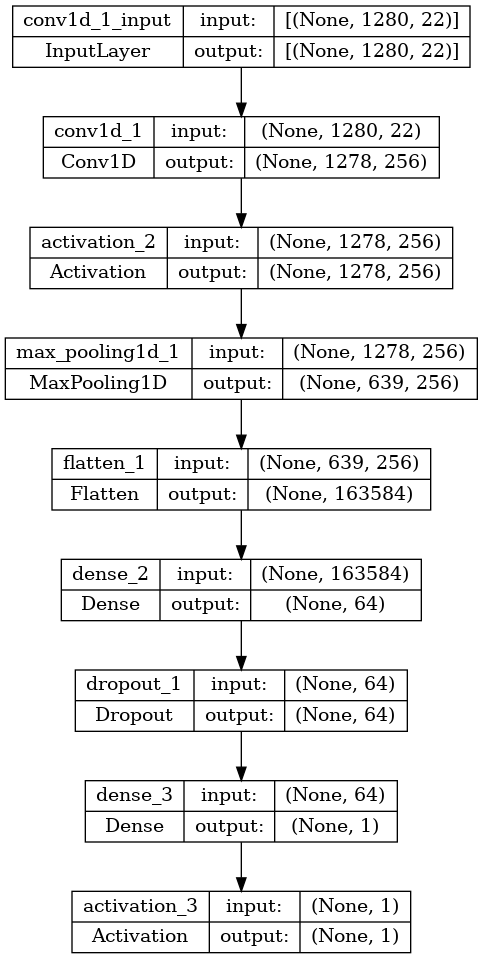

In [36]:
# draw summary
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [37]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


2023-03-12 23:31:07.442515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 5s 51ms/step - loss: 763.7961 - accuracy: 0.6339 - val_loss: 4.5124 - val_accuracy: 0.9762
Epoch 2/10
 3/21 [===>..........................] - ETA: 0s - loss: 129.3240 - accuracy: 0.7812

2023-03-12 23:31:12.293056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 23:31:12.323693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 23:31:12.323817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10171 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


21/21 [==============================] - 1s 28ms/step - loss: 41.3096 - accuracy: 0.9360 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
21/21 [==============================] - 1s 26ms/step - loss: 6.4416 - accuracy: 0.9866 - val_loss: 11.6513 - val_accuracy: 0.9524
Epoch 4/10
21/21 [==============================] - 1s 28ms/step - loss: 0.5699 - accuracy: 0.9940 - val_loss: 3.2427 - val_accuracy: 0.9881
Epoch 5/10
21/21 [==============================] - 1s 28ms/step - loss: 1.2912 - accuracy: 0.9970 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/10
21/21 [==============================] - 1s 28ms/step - loss: 0.1531 - accuracy: 0.9985 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
21/21 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
21/21 [==============================] - 1s 28ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.000

In [39]:
# evaluate model
score = model.evaluate(X_test, y_test, batch_size=32)
print("Test loss:", score[0])

3/3 [==============================] - 0s 75ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0


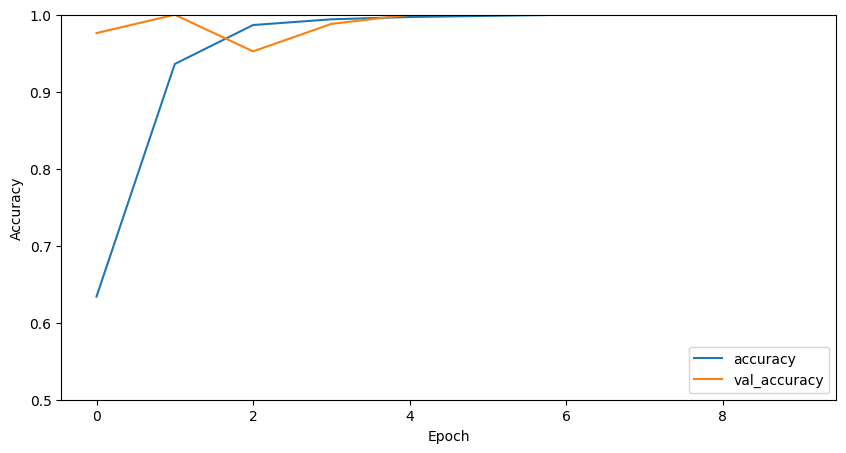

In [40]:
# plot history
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)